In [7]:
from transfer_learning import TransferLearning
from sklearn import svm
import matplotlib.pyplot as plt


In [2]:
L = 5
bond  = 10
TF = TransferLearning(L = L, bond = bond)

In [6]:
train_set  = TF.generate_trainset()

Generating train set: 100%|██████████| 185/185 [00:01<00:00, 151.56it/s]


In [6]:
test_set = TF.generate_testset()

Generating test set: 100%|██████████| 400/400 [00:01<00:00, 329.95it/s]


In [4]:
gram_train = TF.get_kernel_train()

Computing Gram matrix for training set...


Gram Train: 100%|██████████| 34225/34225 [00:06<00:00, 5038.17it/s] 

Gram matrix for training set computed in 8.30 seconds.


In [3]:
gram_test = TF.get_kernel_test()

Computing Gram matrix for test set...


Gram Test: 100%|██████████| 400/400 [00:27<00:00, 14.29it/s]

Gram matrix for testing set computed in 37.10 seconds.


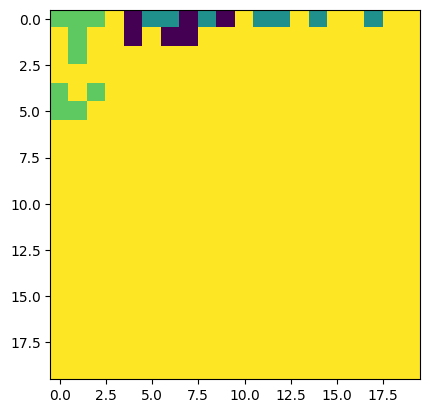

In [11]:
clf = svm.SVC(kernel='precomputed')

y = train_set[1]
clf.fit(gram_train**(5), y) 
y_pred = clf.predict(gram_test)
plt.imshow(y_pred.reshape(20,20))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()